# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf

import math
import numpy as np
from enum import Enum
from collections import defaultdict

%matplotlib inline

# Use development mode to subset a small amount
# of examples for quick iteration on the code.
# Set it to False on the final run
DEVELOP_MODE = False
DEVELOP_SIZE = 2000

In [2]:
# dir argument is supposed to be a glob pattern see: https://github.com/tensorflow/models/blob/bce895d9c18fb47d9c304ebd49c58c03671c67a3/research/object_detection/builders/dataset_builder.py#L78
# doc on glob pattern i.e. tf.io.gfile.glob: https://www.tensorflow.org/api_docs/python/tf/io/gfile/glob

tfrecord_path = "/app/project/data/*.tfrecord"
dataset = get_dataset(tfrecord_path)

if DEVELOP_MODE:
    dataset = dataset.take(DEVELOP_SIZE)

dataset_size = dataset.reduce(0, lambda count, _: count + 1).numpy()

print("Number of examples in a dataset:", dataset_size)

# get image size assuming it is the same for all images
ex = next(iter(dataset.take(1)))
im_height, im_width = ex['original_image_spatial_shape'].numpy()

INFO:tensorflow:Reading unweighted datasets: ['/app/project/data/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/app/project/data/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 798
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


2022-06-06 17:14:43.708614: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Number of examples in a dataset: 15947


I have decided to use all availabla examples. As we can see there are 798 TFRecords that comprise 15947 examples. An example in TensorFlow lingo is an image together with labels, bounding boxes data etc.

## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a dataset as an input and displays an images with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def display_instances(dataset, num_images=16):
    """
    This function takes a dataset with object detection examples [1]
    and displays images with the associated bounding boxes.

    Args:
        dataset: A `tf.data.Dataset` object with object detection examples [1]
        num_images: Number of example images to display

    [1] https://github.com/tensorflow/models/blob/a77f240fc39cd9baa2ab897af5fcec5551a0e85a/research/object_detection/data_decoders/tf_example_decoder.py#L499
    """

    cols = 4
    rows = math.ceil(num_images / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(12, 12))
    for n, ex in enumerate(dataset.take(num_images)):
        i = n // cols
        j = n %  cols
        ax = axs[i, j]

        im = ex["image"].numpy()
        axs[i, j].imshow(im)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)

        boxes = ex["groundtruth_boxes"].numpy()
        classes = ex["groundtruth_classes"].numpy()

        clrs = {1: 'red', 2: 'blue', 4: 'green'}

        for box, label in zip(boxes, classes):
            xy = box[1]*im.shape[1], box[0]*im.shape[0]
            h = (box[2] - box[0]) * im.shape[0]
            w = (box[3] - box[1]) * im.shape[1]
            rec = mpatches.Rectangle(xy, w, h, linewidth=1, edgecolor=clrs[label], facecolor='none')
            ax.add_patch(rec)

    plt.subplots_adjust(wspace=0.01, hspace=0.01, top=1, bottom=0, left=0, right=1)

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

In [4]:
# dataset_size is 15947, it cannot be fully shuffled
# as 32GB of RAM on my machine isn't enough for that,
#  hence resort to a smaller buffer_size
buffer_size = 1000

# I also set seed and reshuffle_each_iteration to get reproducible results
dataset_shuffled = dataset.shuffle(buffer_size, seed=0, reshuffle_each_iteration=False)

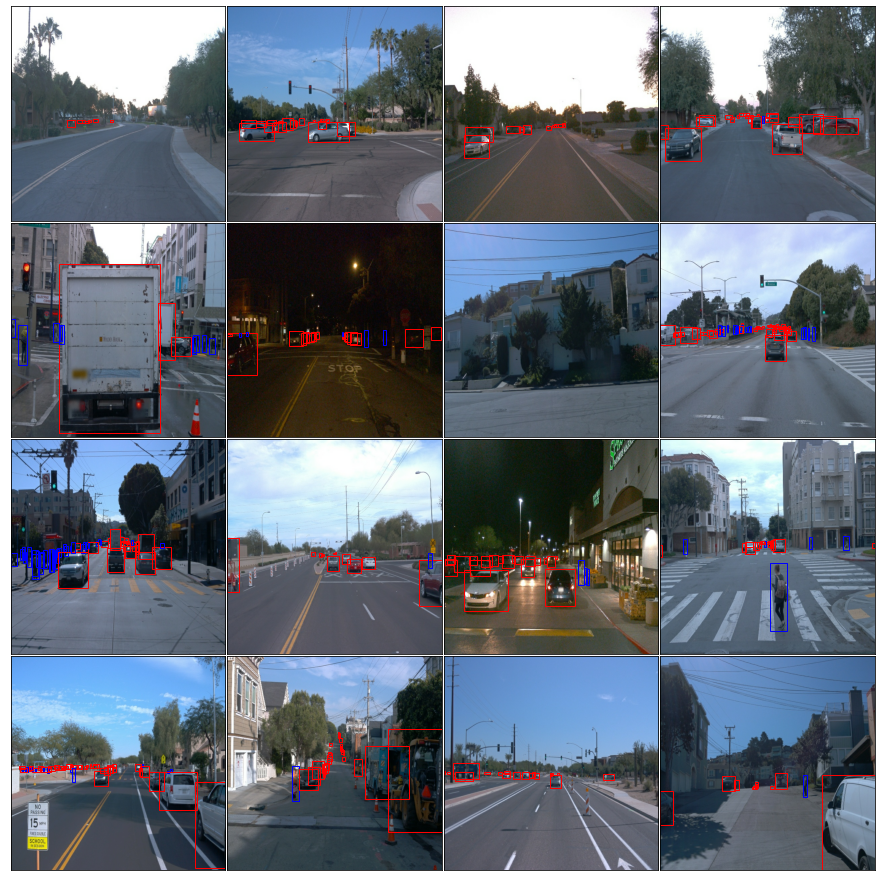

In [5]:
display_instances(dataset_shuffled, 16)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

### How many day time and night time images are there?

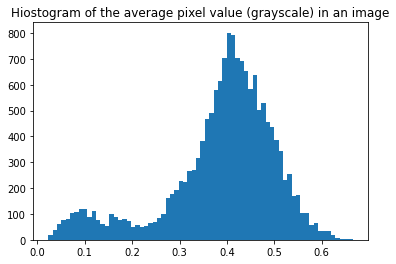

In [6]:
def avg_grayscale_value(im):
    return tf.divide(
        tf.reduce_sum(tf.cast(im, dtype=tf.float32)), # sum all pixel values in an image 
        tf.constant(im_height * im_width * 255 * 3, dtype=tf.float32)) # normalize

def avg(ex):
    return avg_grayscale_value(ex["image"])

avg_ds = dataset.map(avg)
plt.hist(np.fromiter(avg_ds, np.double), bins='auto')
plt.title("Hiostogram of the average pixel value (grayscale) in an image");

Clearly, there are two peaks. One for night time images and one for day time images. The dataset has many more day time images, it is **not balanced** in this regard.

Let us pick a threshold for a night time or a daytime image at a value of 0.25 and plot some images of each class.

In [7]:
TIME_THRESHOLD = 0.25

class TimeOfDay(Enum):
    NIGHT = 1
    DAY = 2

def time_of_day(im):
    avg = avg_grayscale_value(im)
    if avg < TIME_THRESHOLD:
        return tf.constant(TimeOfDay.NIGHT.value)
    else:
        return tf.constant(TimeOfDay.DAY.value)

dataset_night = dataset.filter(lambda ex : time_of_day(ex["image"]) == tf.constant(TimeOfDay.NIGHT.value))
dataset_day = dataset.filter(lambda ex : time_of_day(ex["image"]) == tf.constant(TimeOfDay.DAY.value))

Let's take a look at some night time images.

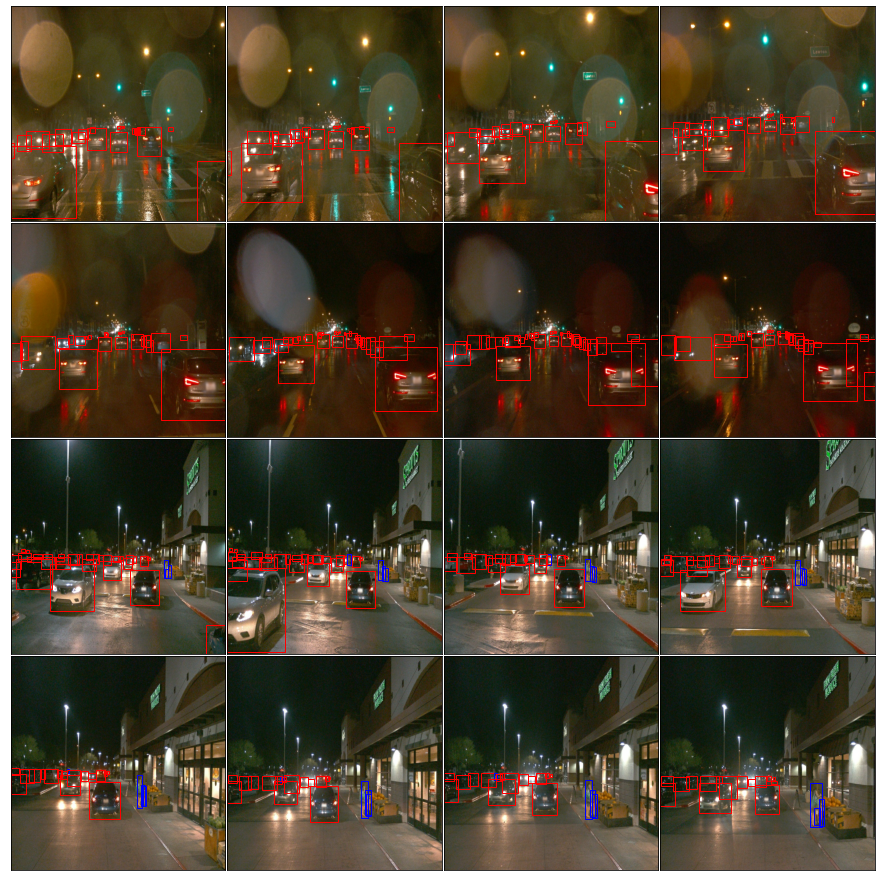

In [8]:
display_instances(dataset_night, 16)

What about day time images?

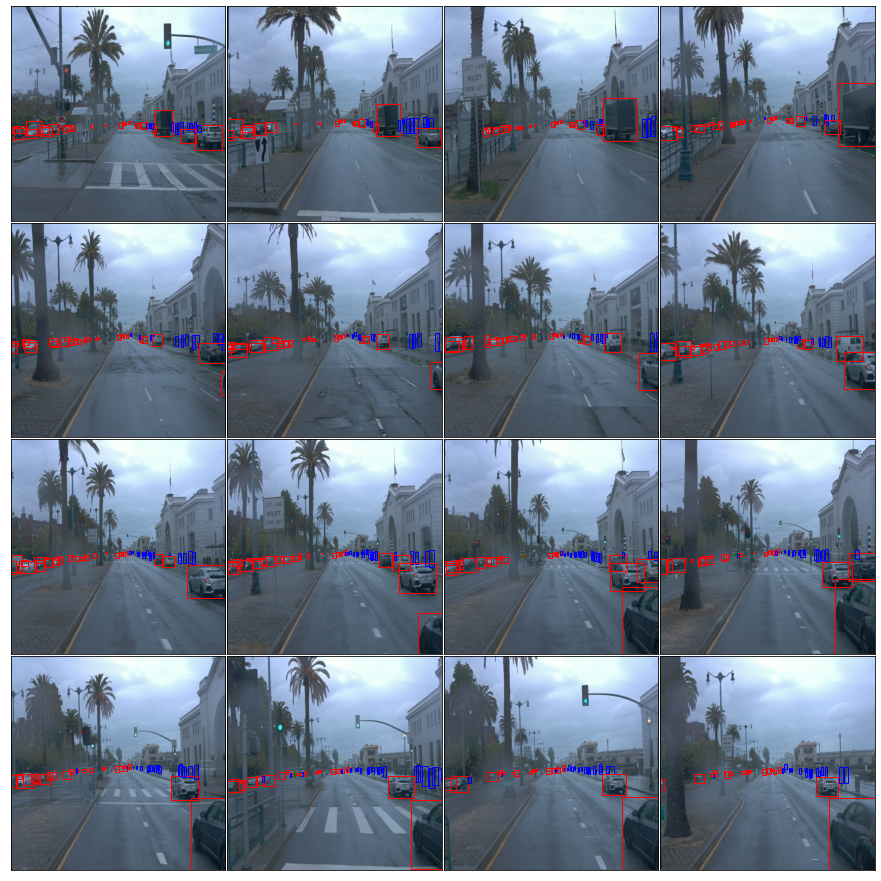

In [9]:
display_instances(dataset_day, 16)

### How many objects of each class are there?

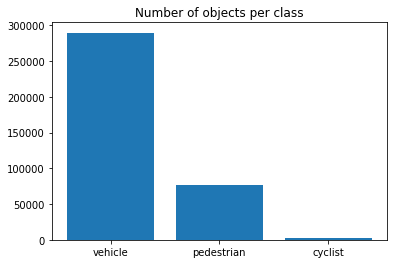

In [10]:
class_names = {1: 'vehicle', 2: 'pedestrian', 4: 'cyclist'}
classes = defaultdict(int)
for ex in dataset.as_numpy_iterator():
    for class_id in ex["groundtruth_classes"]:
        classes[class_id] += 1

bar_names = []
bar_heights = []
for key in class_names:
    bar_heights.append(classes[key])
    bar_names.append(class_names[key])
plt.bar(bar_names, bar_heights)
plt.title("Number of objects per class");

There are few objects of class cyclist in the dataset. If our detection of them is not good enough we might need to find more examples of cyclists.

Again, we see that the dataset is not well balanced. There are very few cyclists. We will keep an eye also on the model performance on pedestrians.

### How many objects are there per image?
It would be interesting to know if number of objects per image is more or less the same.

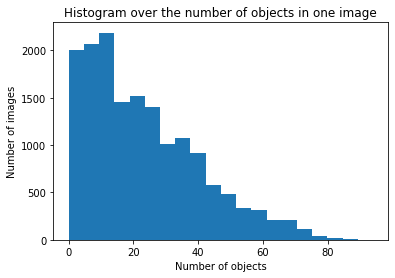

In [11]:
d = dataset.map(lambda ex: len(ex["groundtruth_classes"]))
plt.hist(np.fromiter(d, np.double), bins=20)
plt.title("Histogram over the number of objects in one image")
plt.xlabel("Number of objects")
plt.ylabel("Number of images");

We do not notice any irregularities in the data. Images with 10 to 20 objects are the most common ones.